In [1]:
"""
Brief Description:
This repository contains the solution for a case study involves building a Multiple Linear Regression model to predict the demand for shared bikes. 
The goal is to identify significant factors influencing bike rentals and understand how these variables impact demand dynamics. 
This model will enable the management of BoomBikes, a bike-sharing provider, to strategize and optimize their operations in the post-pandemic scenario.

1. Load and Understand the Dataset
2. Data Quality Checks
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas display options
# Display all columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 100) 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the dataset
data_path = "day.csv"  # Update with the correct path if needed
data = pd.read_csv(data_path, low_memory=False)

# 1. Inspect the Dataset
# Display basic information about the dataset
print("Dataset Info:\n")
data.info()

# Display summary statistics
print("\nSummary Statistics:\n")
print(data.describe())

###Data Quality Checks

# Address Missing Values
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:\n")
print(missing_values)

# Impute or remove missing values
for column in data.columns:
    if data[column].isnull().sum() > 0:
        if data[column].dtype == 'object':
            # Impute categorical variables with mode
            data[column].fillna(data[column].mode()[0], inplace=True)
        else:
            # Impute numerical variables with median
            data[column].fillna(data[column].median(), inplace=True)

print("\nMissing values addressed.\n")

# Check columns for utility
# Dropping 'instant' as it's just an index and not relevant for analysis
if 'instant' in data.columns:
    data = data.drop(columns=['instant'])
    print("Column 'instant' dropped.")



# 3. Feature Engineering
# Example feature: rental ratio
# Create a new feature for the ratio of casual to registered users
data['casual_registered_ratio'] = data['casual'] / (data['registered'] + 1)  # Avoid division by zero

# Document the rationale for feature engineering
print("\nNew feature 'casual_registered_ratio' added to better understand user behavior.\n")

# 4. Data Type and Format Adjustments
# Convert 'dteday' to datetime format
data['dteday'] = pd.to_datetime(data['dteday'], format='%d-%m-%Y')

# Extract year and month from the date for further analysis
data['year'] = data['dteday'].dt.year
data['month'] = data['dteday'].dt.month

print("\nDate column 'dteday' cleaned and additional features 'year' and 'month' derived.\n")

# Final dataset inspection
print("\nDataset after cleaning and manipulation:\n")
data.info()

# Define mappings
season_mapping = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
weather_mapping = {
    1: 'Clear',
    2: 'Mist',
    3: 'Light Snow/Rain',
    4: 'Heavy Rain/Snow'
}
year_mapping = {0: 2018, 1: 2019}

# Apply mappings using map()
data['season'] = data['season'].map(season_mapping)
data['weathersit'] = data['weathersit'].map(weather_mapping)
data['yr'] = data['yr'].map(year_mapping)

# Validate the mappings
print("\nMapped 'season', 'weathersit', and 'yr' columns:")
print(data[['season', 'weathersit', 'yr']].head())

# Additional Inspection
print("\nUnique values after mapping:")
print("Season:", data['season'].unique())
print("Weather Situation:", data['weathersit'].unique())
print("Year:", data['yr'].unique())



Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB

Summary Statistics:

       instant  season     yr   mnth  holiday  weekday  

In [3]:
"""
o	Range of values to identify outliers or inconsistencies.
"""

df = pd.DataFrame(data)

# Function to calculate IQR and identify outliers
def detect_outliers_iqr(df, columns):
    outliers_info = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)  # First quartile
        Q3 = df[col].quantile(0.75)  # Third quartile
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outliers_info[col] = {
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Outliers': outliers.tolist()
        }
    
    return outliers_info

# List of numerical columns to analyze
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'casual_registered_ratio']

# Detect outliers
outliers_info = detect_outliers_iqr(df, numerical_columns)

# Display the results
for col, info in outliers_info.items():
    print(f"Column: {col}")
    print(f"  Lower Bound: {info['Lower Bound']}")
    print(f"  Upper Bound: {info['Upper Bound']}")
    print(f"  Outliers: {info['Outliers']}\n")

Column: temp
  Lower Bound: -5.7912089999999985
  Upper Bound: 46.483709
  Outliers: []

Column: atemp
  Lower Bound: -3.444381249999992
  Upper Bound: 50.77986874999999
  Outliers: []

Column: hum
  Lower Bound: 20.515637499999997
  Upper Bound: 104.4739375
  Outliers: [18.7917, 0.0]

Column: windspeed
  Lower Bound: -0.8342588749999997
  Upper Bound: 25.501498125
  Outliers: [27.999836, 34.000021, 25.833257, 26.000489, 28.292425, 27.833743, 27.417204, 28.250014, 29.584721, 27.7916, 25.917007, 26.666536, 27.292182]

Column: casual
  Lower Bound: -854.125
  Upper Bound: 2266.875
  Outliers: [2355, 2282, 3065, 2418, 2521, 2397, 3155, 2469, 2301, 2347, 3252, 2795, 2846, 2541, 2496, 2622, 3410, 2704, 2855, 3283, 2557, 2795, 2494, 2708, 2963, 2634, 2657, 2551, 2562, 2355, 2544, 2345, 2827, 2352, 2613, 2570, 3160, 2512, 2454, 2589, 3031, 2806, 2643, 2290]

Column: registered
  Lower Bound: -919.25
  Upper Bound: 8204.75
  Outliers: []

Column: cnt
  Lower Bound: -1024.625
  Upper Bound: 101

In [5]:
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,casual_registered_ratio,year,month
0,2018-01-01,Spring,2018,1,0,6,0,Mist,14.11,18.18,80.58,10.75,331,654,985,0.51,2018,1
1,2018-01-02,Spring,2018,1,0,0,0,Mist,14.90,17.69,69.61,16.65,131,670,801,0.20,2018,1
2,2018-01-03,Spring,2018,1,0,1,1,Clear,8.05,9.47,43.73,16.64,120,1229,1349,0.10,2018,1
3,2018-01-04,Spring,2018,1,0,2,1,Clear,8.20,10.61,59.04,10.74,108,1454,1562,0.07,2018,1
4,2018-01-05,Spring,2018,1,0,3,1,Clear,9.31,11.46,43.70,12.52,82,1518,1600,0.05,2018,1



Categorical variables converted to dummy variables with drop_first=True.


Dataset after cleaning and manipulation:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   dteday                   730 non-null    datetime64[ns]
 1   yr                       730 non-null    int64         
 2   holiday                  730 non-null    int64         
 3   weekday                  730 non-null    int64         
 4   workingday               730 non-null    int64         
 5   temp                     730 non-null    float64       
 6   atemp                    730 non-null    float64       
 7   hum                      730 non-null    float64       
 8   windspeed                730 non-null    float64       
 9   casual                   730 non-null    int64         
 10  registered               730 non-null   

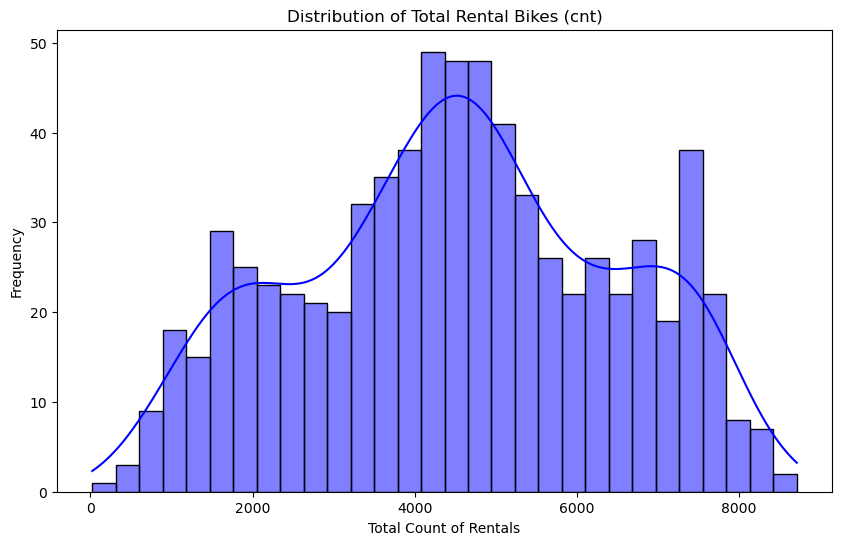

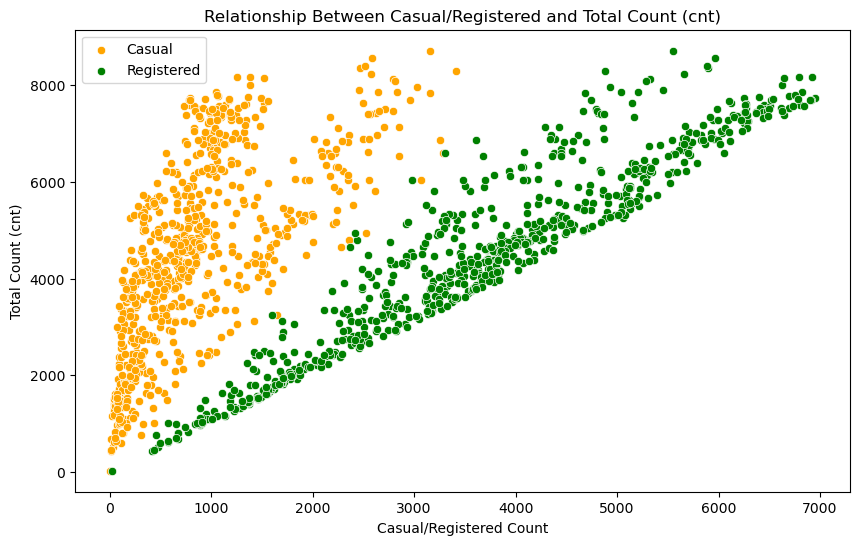

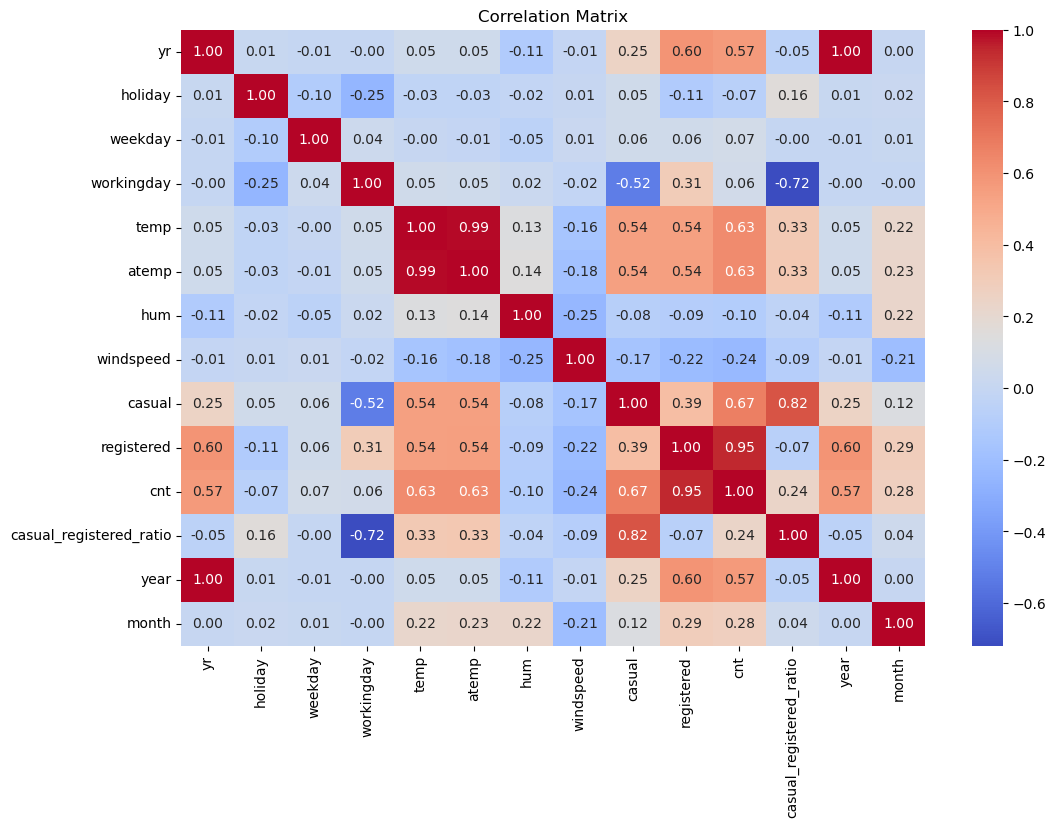

In [7]:
"""
Handle Categorical Variables
"""
# Replace numeric codes with descriptive labels
data['season'] = data['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
data['weathersit'] = data['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'Light Snow', 4: 'Heavy Rain'})
data['mnth'] = data['mnth'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})


# Check if categorical variables need remapping
if data['season'].dtype == 'int64':  # Map only if the column contains numeric codes
    data['season'] = data['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
if data['weathersit'].dtype == 'int64':
    data['weathersit'] = data['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'Light Snow', 4: 'Heavy Rain'})
if data['mnth'].dtype == 'int64':
    data['mnth'] = data['mnth'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                                      7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})

# Create dummy variables for categorical features
data = pd.get_dummies(data, columns=['season', 'weathersit', 'mnth'], drop_first=True)

print("\nCategorical variables converted to dummy variables with drop_first=True.\n")

# Final dataset inspection
print("\nDataset after cleaning and manipulation:\n")
data.info()

# 2. Understand the Target Variable (cnt)
# Distribution of the target variable 'cnt'
plt.figure(figsize=(10, 6))
sns.histplot(data['cnt'], kde=True, bins=30, color='blue')
plt.title("Distribution of Total Rental Bikes (cnt)")
plt.xlabel("Total Count of Rentals")
plt.ylabel("Frequency")
plt.show()

# Relationship between 'cnt' and other variables
plt.figure(figsize=(10, 6))
sns.scatterplot(x='casual', y='cnt', data=data, color='orange', label='Casual')
sns.scatterplot(x='registered', y='cnt', data=data, color='green', label='Registered')
plt.title("Relationship Between Casual/Registered and Total Count (cnt)")
plt.xlabel("Casual/Registered Count")
plt.ylabel("Total Count (cnt)")
plt.legend()
plt.show()

# Ensure only numeric columns are used for correlation
numeric_columns = data.select_dtypes(include=['number'])  # Select only numeric columns
correlation = numeric_columns.corr()  # Compute correlation on numeric columns

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#data.head()


In [9]:
from sklearn.preprocessing import StandardScaler

df = pd.DataFrame(data)

# 1. Create Derived Metrics
# Convert 'weekday' into 'day_of_week' (e.g., Monday = 0, Sunday = 6)
# Create 'is_weekend' (1 for Saturday and Sunday, 0 otherwise)
df['day_of_week'] = df['weekday'].apply(lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][x])
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

# 2. Standardize or Normalize Numeric Features
# Select numeric columns for scaling
numeric_features = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'casual_registered_ratio']
scaler = StandardScaler()
df_scaled = df.copy()

# Apply StandardScaler to numeric columns
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

# Show transformed data
print("Derived Metrics Added:")
print(df[['day_of_week', 'is_weekend']])
print("\nStandardized Numeric Features:")
print(df_scaled[numeric_features])

Derived Metrics Added:
    day_of_week  is_weekend
0        Sunday           1
1        Monday           0
2       Tuesday           0
3     Wednesday           0
4      Thursday           0
..          ...         ...
725      Friday           0
726    Saturday           1
727      Sunday           1
728      Monday           0
729     Tuesday           0

[730 rows x 2 columns]

Standardized Numeric Features:
     temp  atemp   hum  windspeed  casual  registered   cnt  \
0   -0.83  -0.68  1.25      -0.39   -0.76       -1.93 -1.82   
1   -0.72  -0.74  0.48       0.75   -1.05       -1.92 -1.92   
2   -1.64  -1.75 -1.34       0.75   -1.06       -1.56 -1.63   
3   -1.62  -1.61 -0.26      -0.39   -1.08       -1.41 -1.52   
4   -1.47  -1.51 -1.34      -0.05   -1.12       -1.37 -1.50   
..    ...    ...   ...        ...     ...         ...   ...   
725 -1.32  -1.52  0.18       2.06   -0.88       -1.15 -1.24   
726 -1.32  -1.35 -0.26      -0.45   -0.30       -0.77 -0.73   
727 -1.32  -1.43  

In [47]:
df.head()

,dteday,yr,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,casual_registered_ratio,year,month,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,mnth_Mar,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,day_of_week,is_weekend
0,2018-01-01,2018,0,6,0,14.11,18.18,80.58,10.75,331,654,985,0.51,2018,1,False,False,False,True,False,False,False,False,False,False,False,Sunday,1
1,2018-01-02,2018,0,0,0,14.90,17.69,69.61,16.65,131,670,801,0.20,2018,1,False,False,False,True,False,False,False,False,False,False,False,Monday,0
2,2018-01-03,2018,0,1,1,8.05,9.47,43.73,16.64,120,1229,1349,0.10,2018,1,False,False,False,True,False,False,False,False,False,False,False,Tuesday,0
3,2018-01-04,2018,0,2,1,8.20,10.61,59.04,10.74,108,1454,1562,0.07,2018,1,False,False,False,True,False,False,False,False,False,False,False,Wednesday,0
4,2018-01-05,2018,0,3,1,9.31,11.46,43.70,12.52,82,1518,1600,0.05,2018,1,False,False,False,True,False,False,False,False,False,False,False,Thursday,0


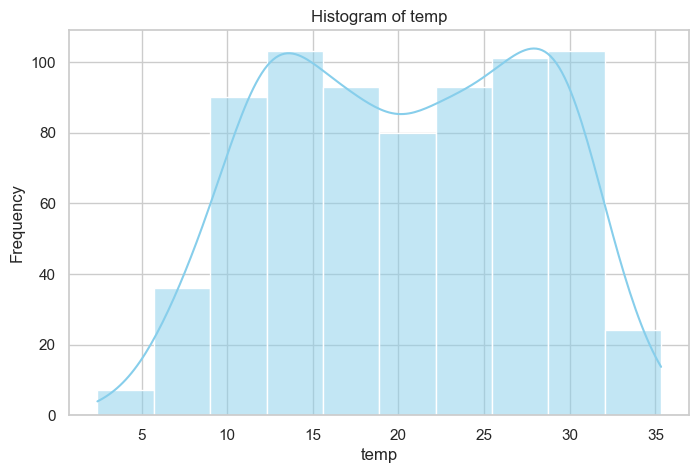

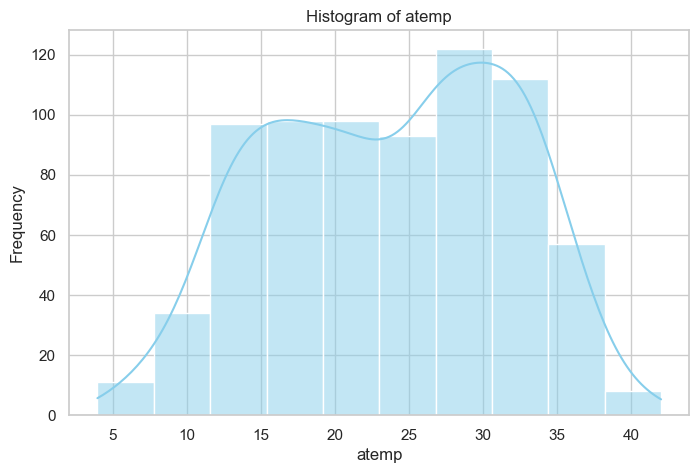

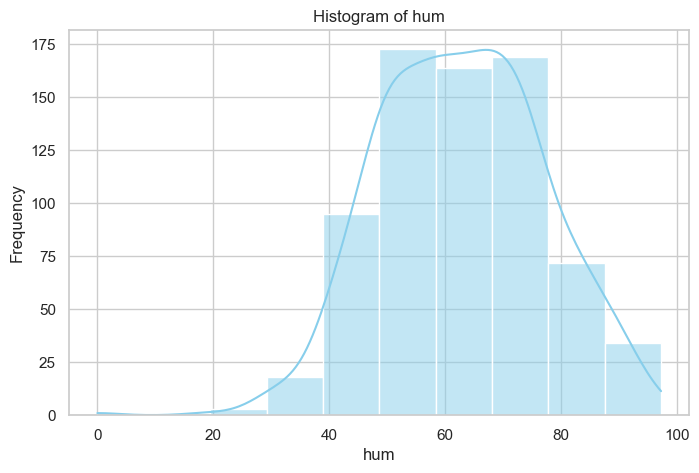

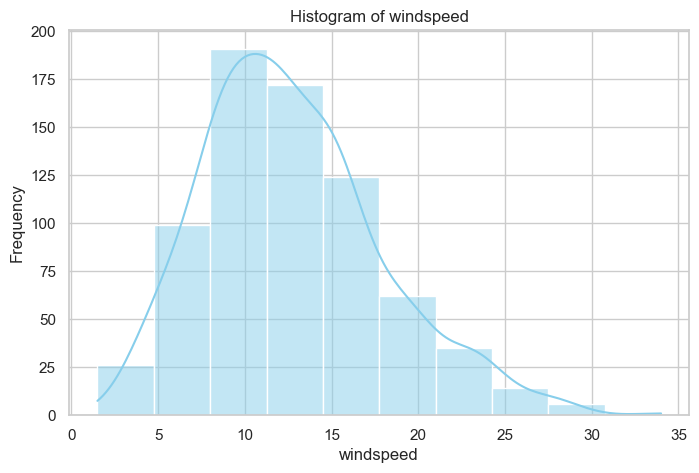

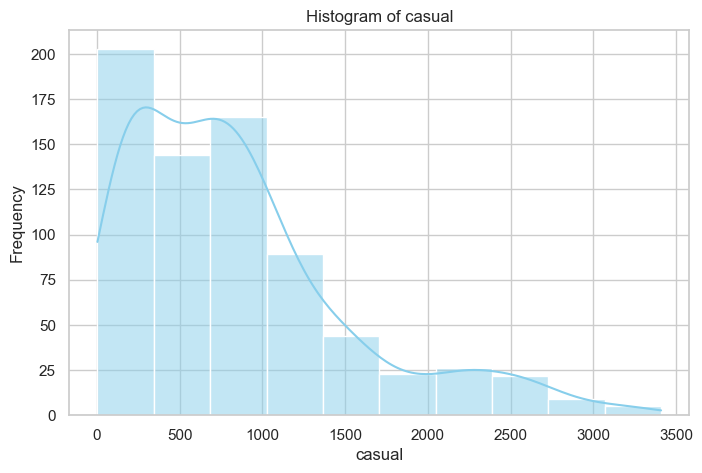

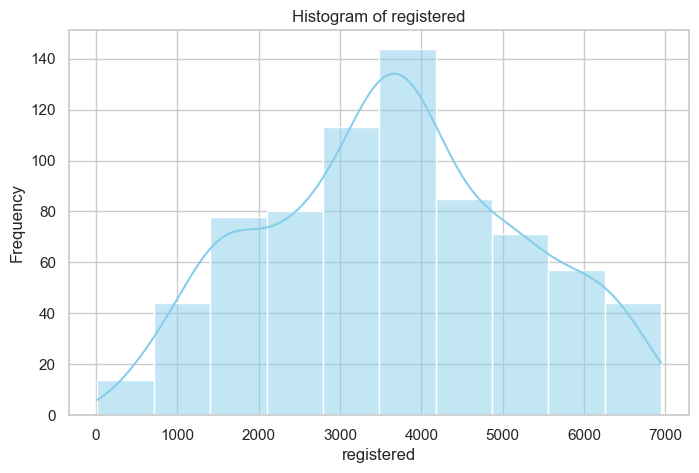

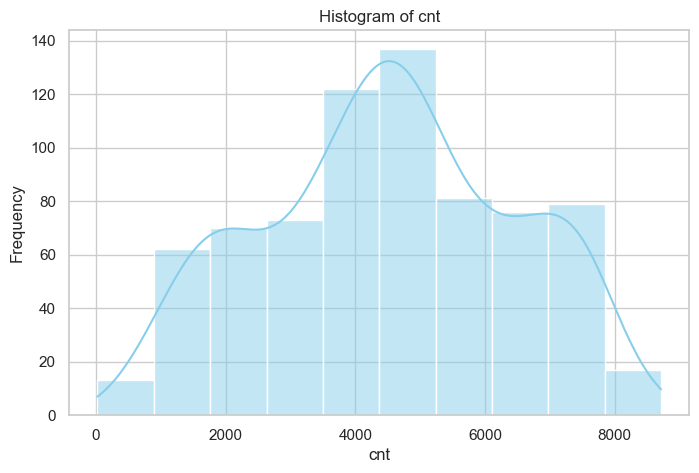

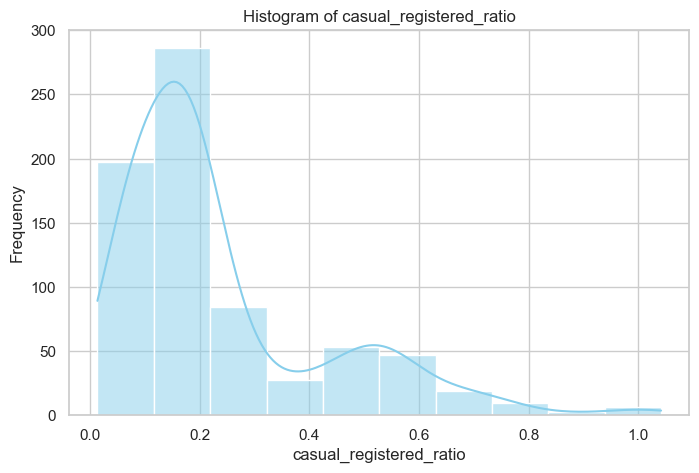

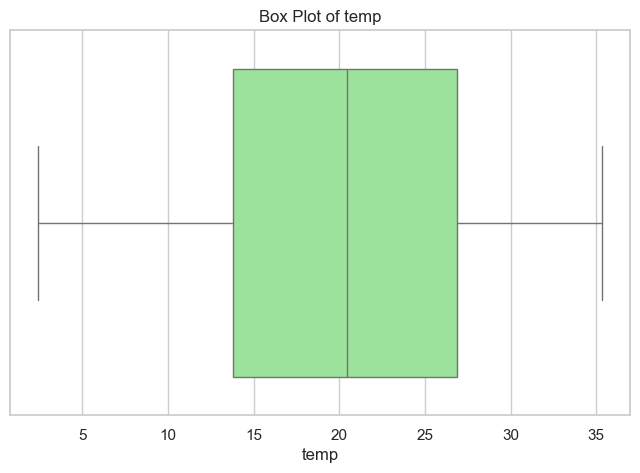

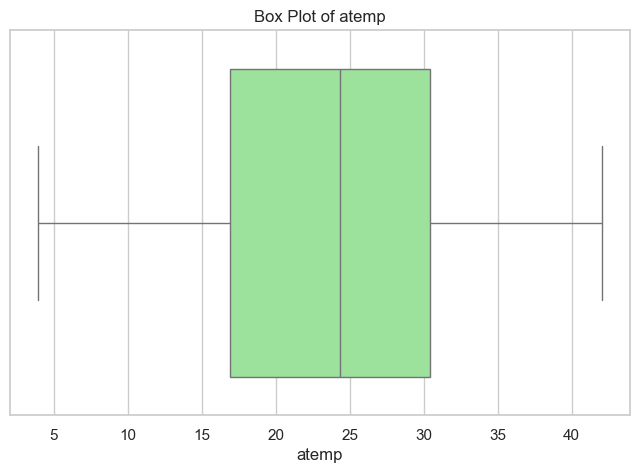

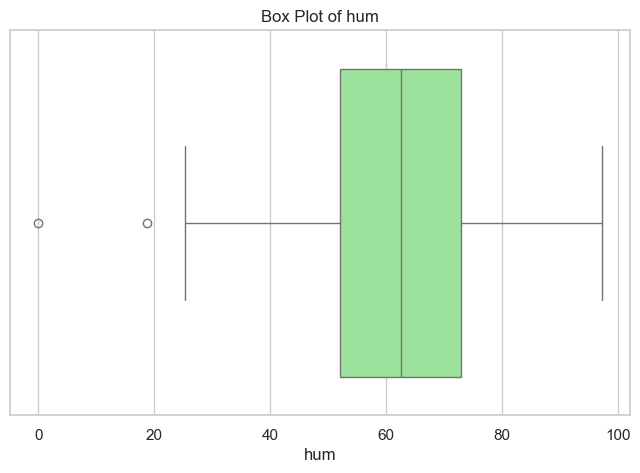

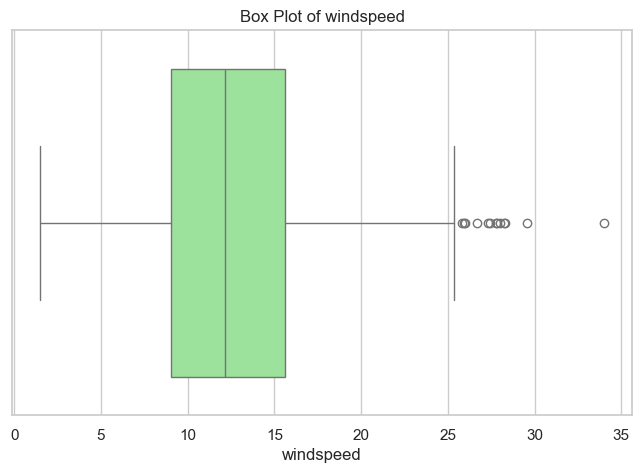

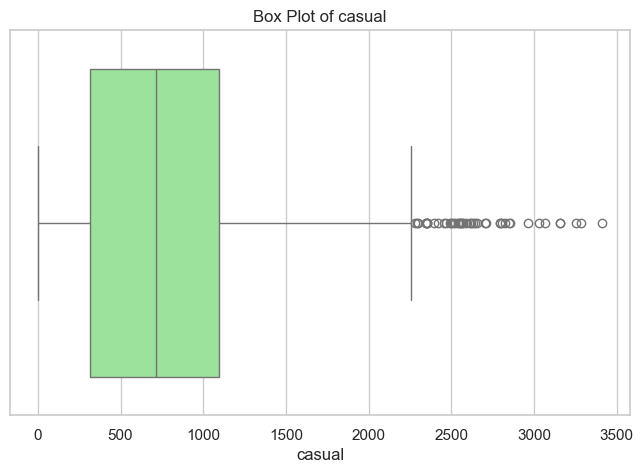

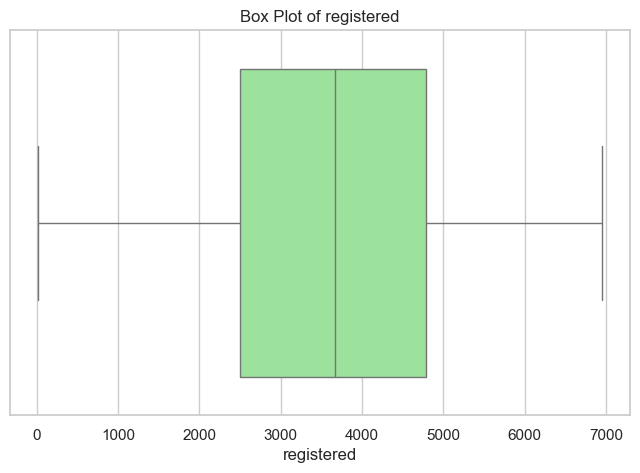

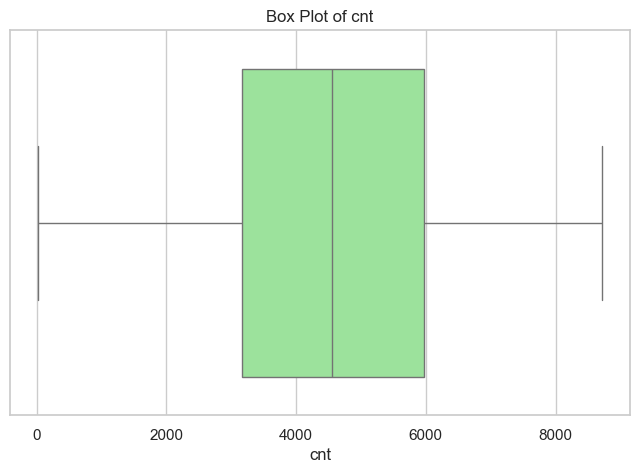

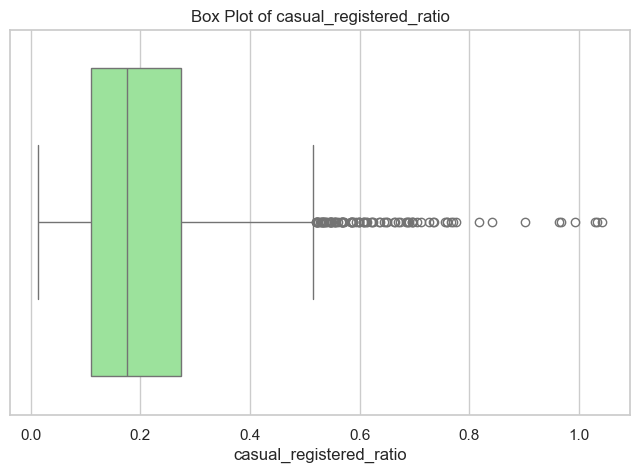

C:\Users\aichb\AppData\Local\Temp\ipykernel_12432\516553388.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


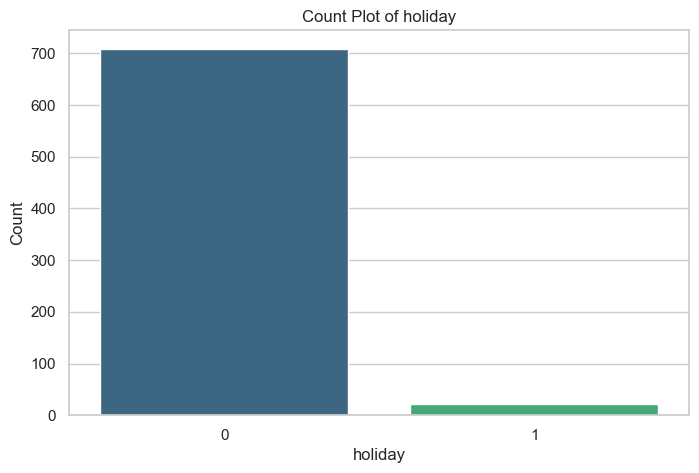

C:\Users\aichb\AppData\Local\Temp\ipykernel_12432\516553388.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


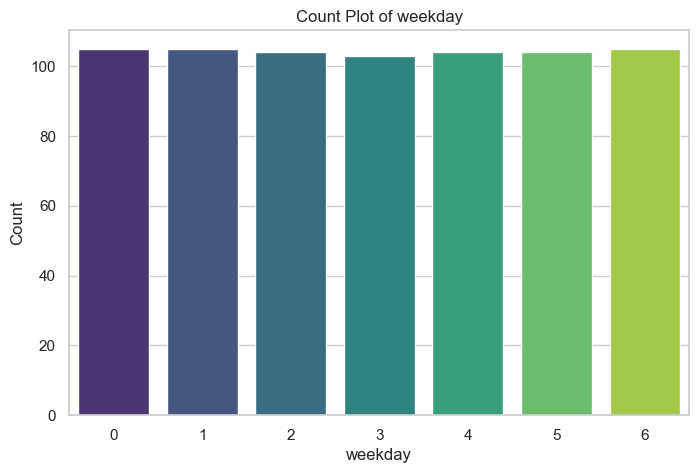

C:\Users\aichb\AppData\Local\Temp\ipykernel_12432\516553388.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


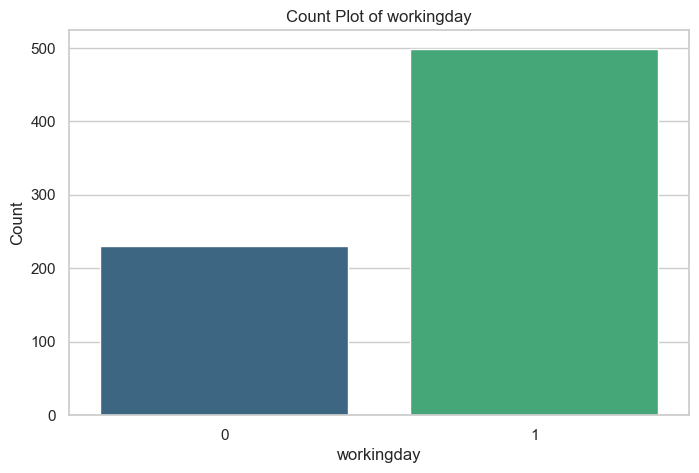

C:\Users\aichb\AppData\Local\Temp\ipykernel_12432\516553388.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


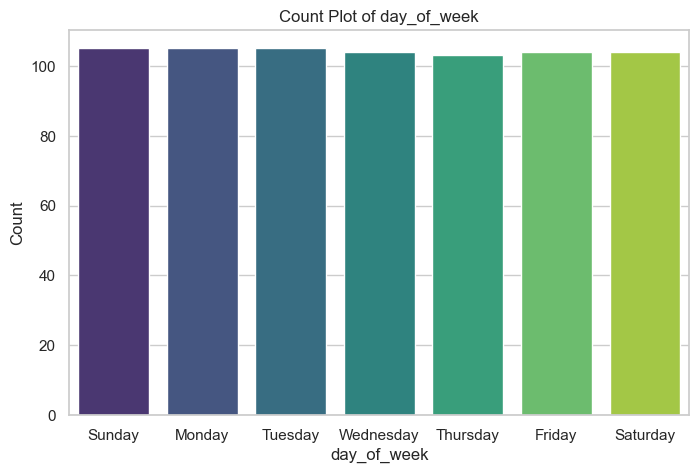

C:\Users\aichb\AppData\Local\Temp\ipykernel_12432\516553388.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette='viridis')


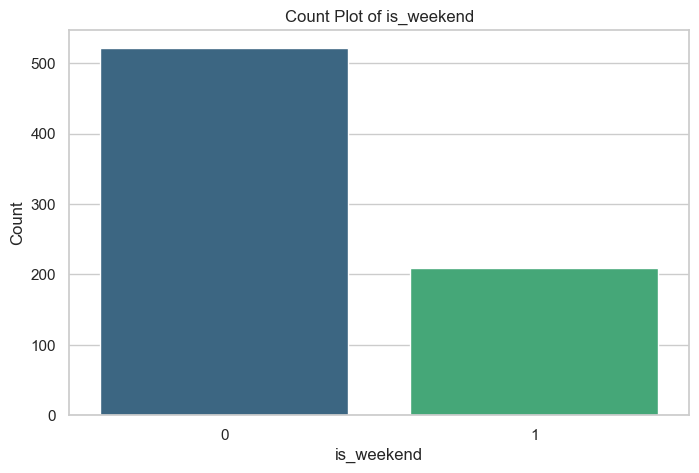

In [11]:

"""
##Exploratory Data Analysis (EDA)
•	Univariate analysis:
o	Plot histograms, box plots, and count plots for each variable.
•	Bivariate analysis:
o	Examine the correlation between independent variables and the target variable (cnt) using heatmaps.

"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Plot Histograms for numeric variables
numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'casual_registered_ratio']
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True, bins=10, color='skyblue')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Plot Box Plots for numeric variables
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Box Plot of {col}")
    plt.xlabel(col)
    plt.show()

# Plot Count Plots for categorical variables
categorical_columns = ['holiday', 'weekday', 'workingday', 'day_of_week', 'is_weekend']
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df[col], palette='viridis')
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()



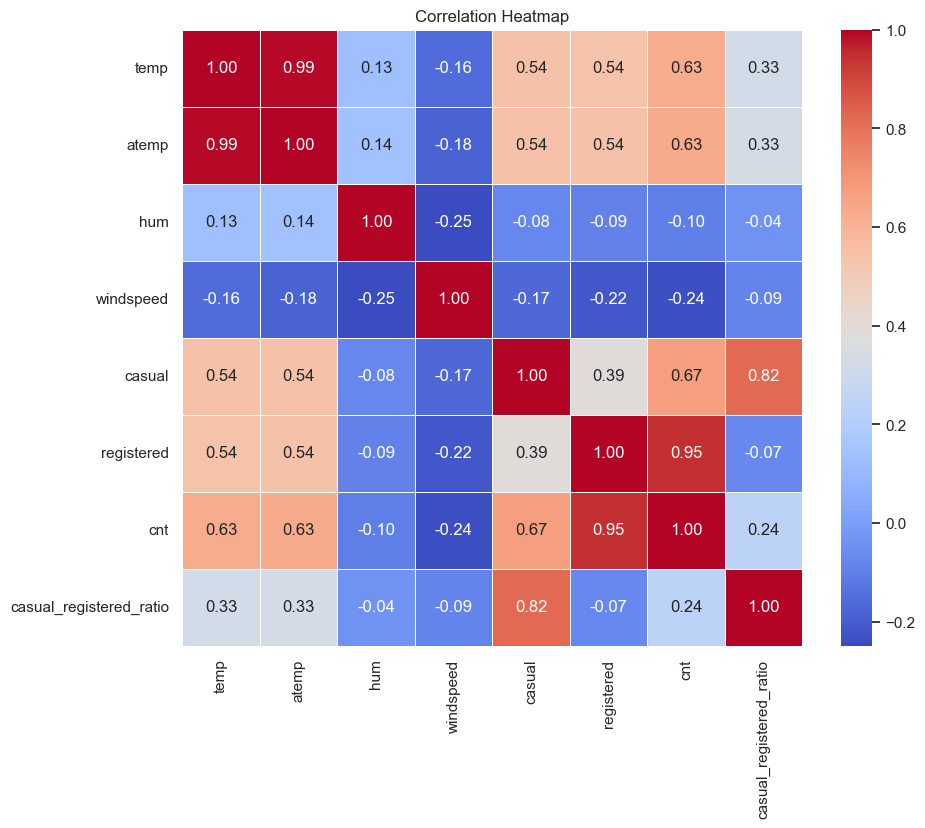

In [13]:
"""
•	Bivariate analysis:
o	Examine the correlation between independent variables and the target variable (cnt) using heatmaps.

perform bivariate analysis by examining the correlation between independent variables and the target variable (cnt) using a heatmap:

"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix for numeric columns
numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'casual_registered_ratio']
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

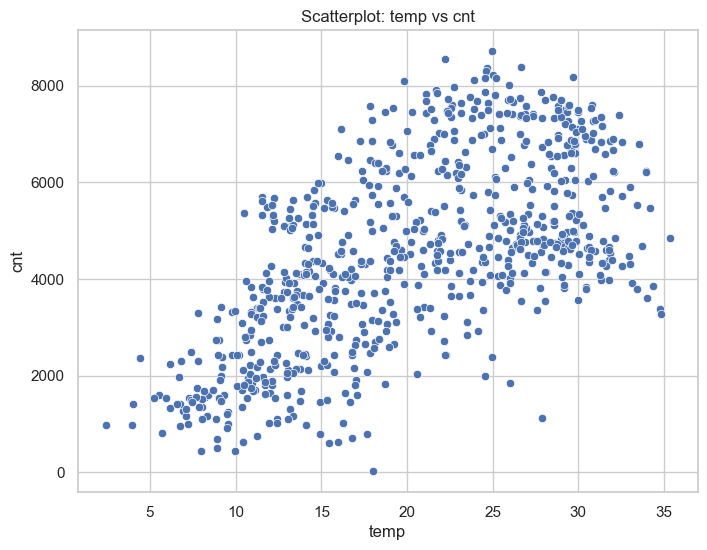

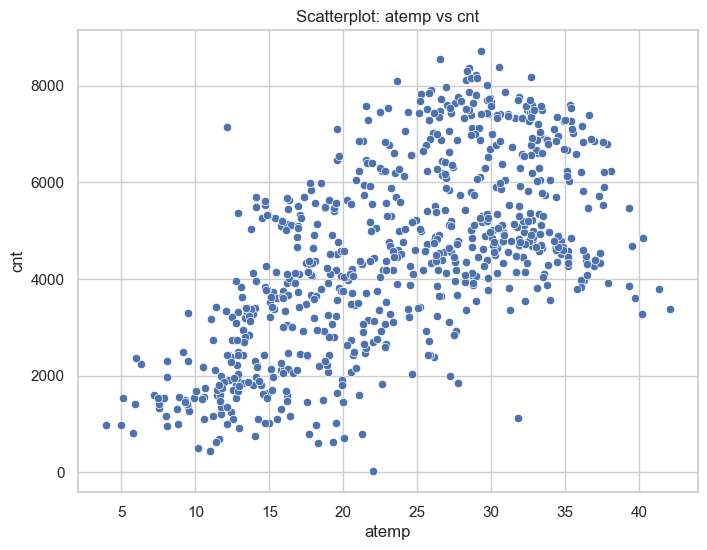

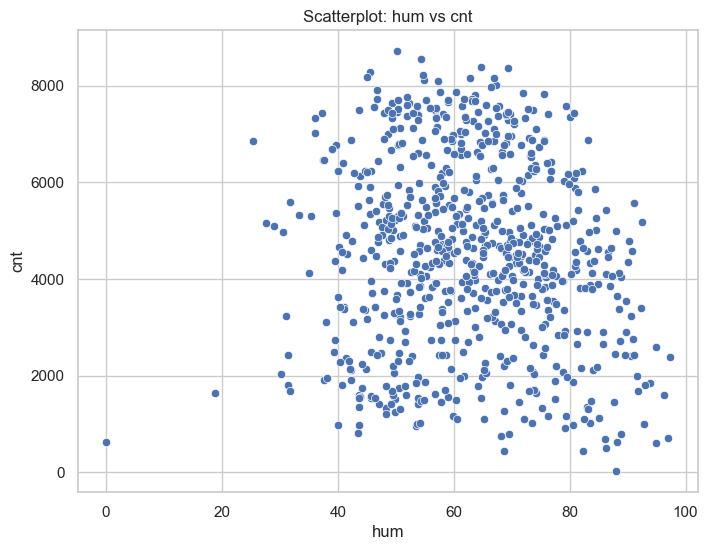

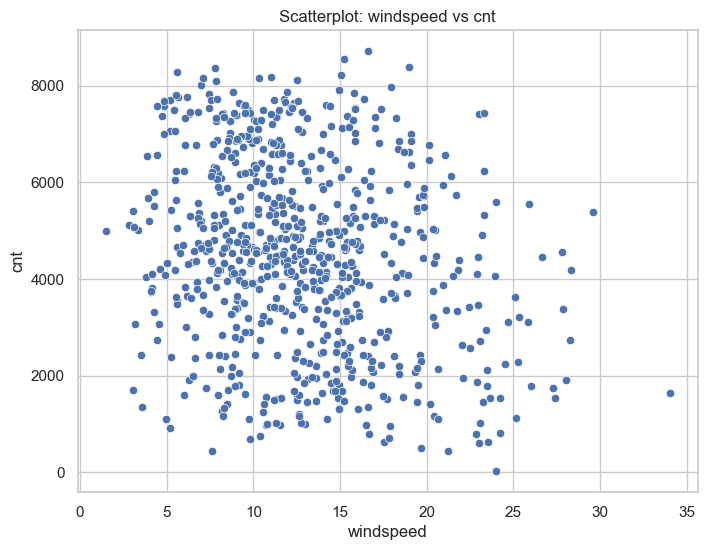

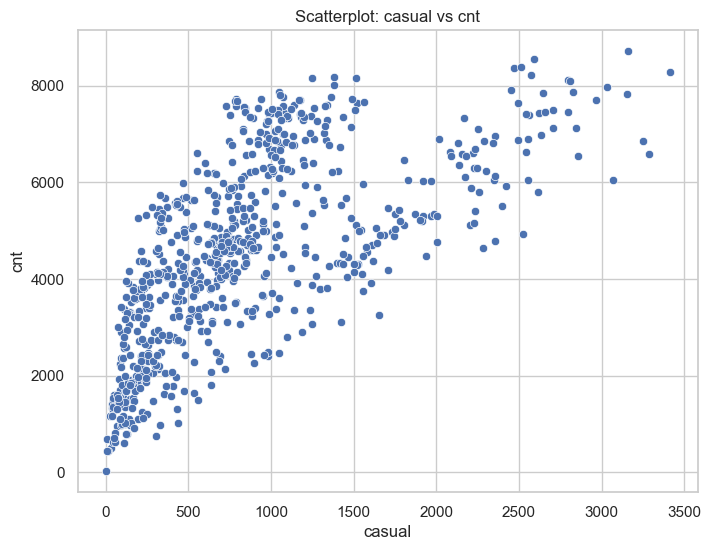

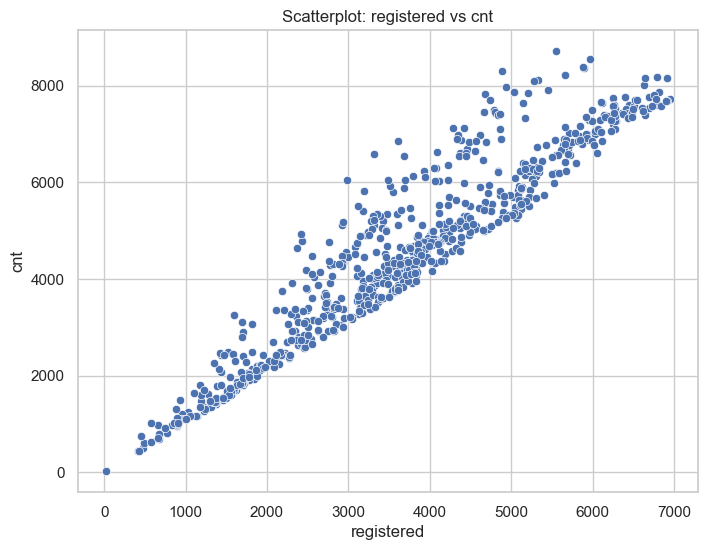

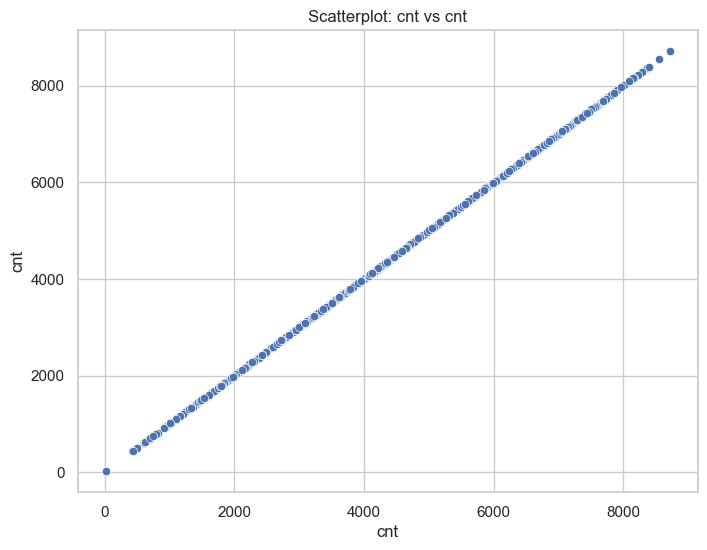

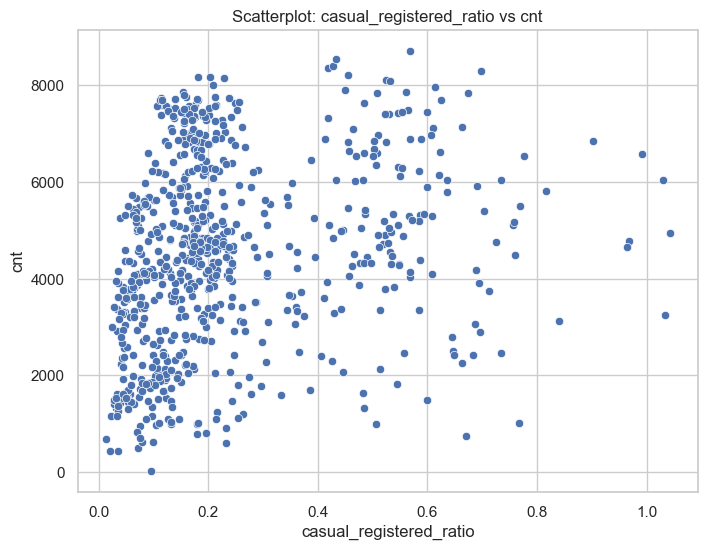

C:\Users\aichb\AppData\Local\Temp\ipykernel_20996\2762058177.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y='cnt', ci=None)


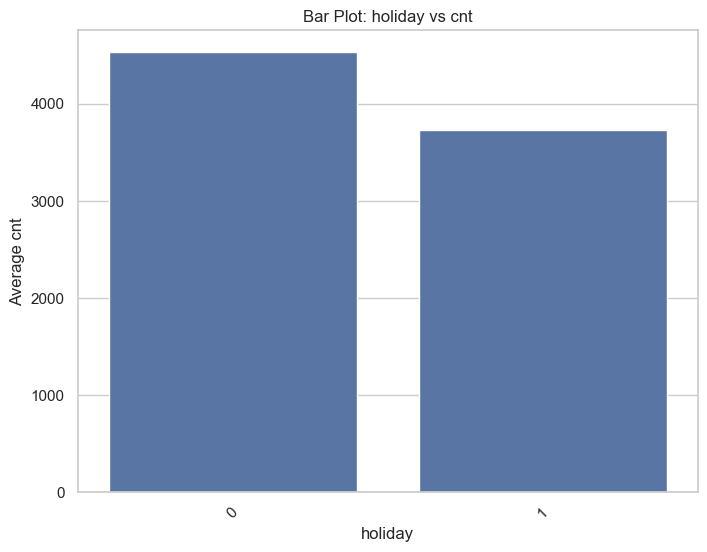

C:\Users\aichb\AppData\Local\Temp\ipykernel_20996\2762058177.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y='cnt', ci=None)


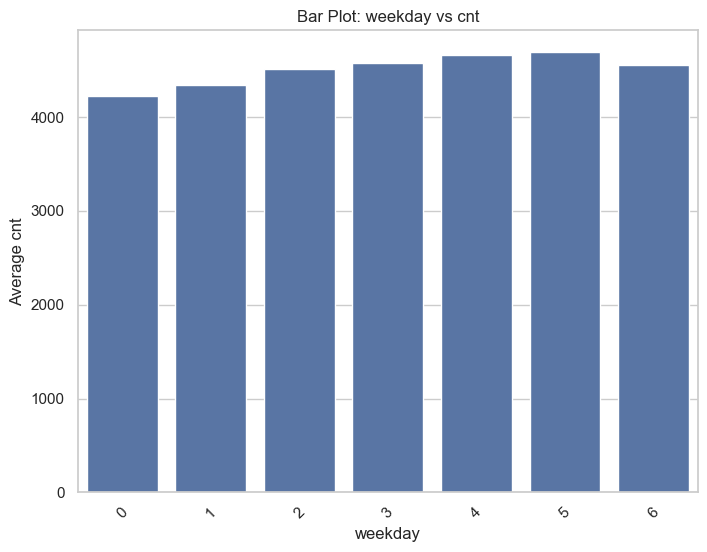

C:\Users\aichb\AppData\Local\Temp\ipykernel_20996\2762058177.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y='cnt', ci=None)


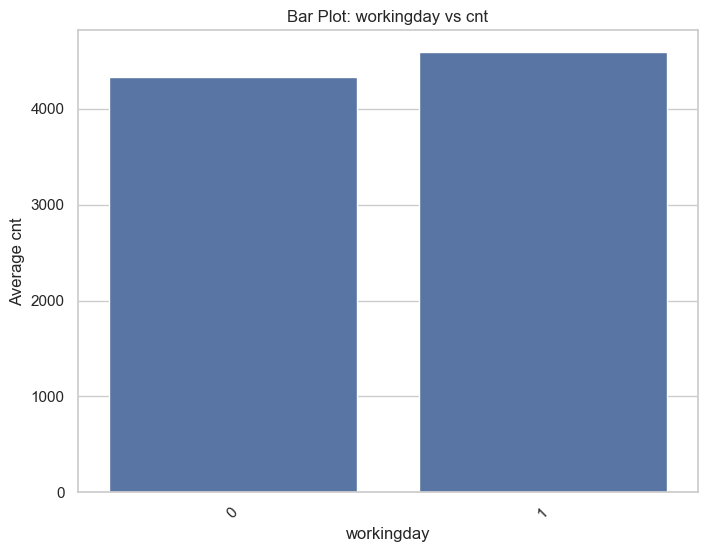

C:\Users\aichb\AppData\Local\Temp\ipykernel_20996\2762058177.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y='cnt', ci=None)


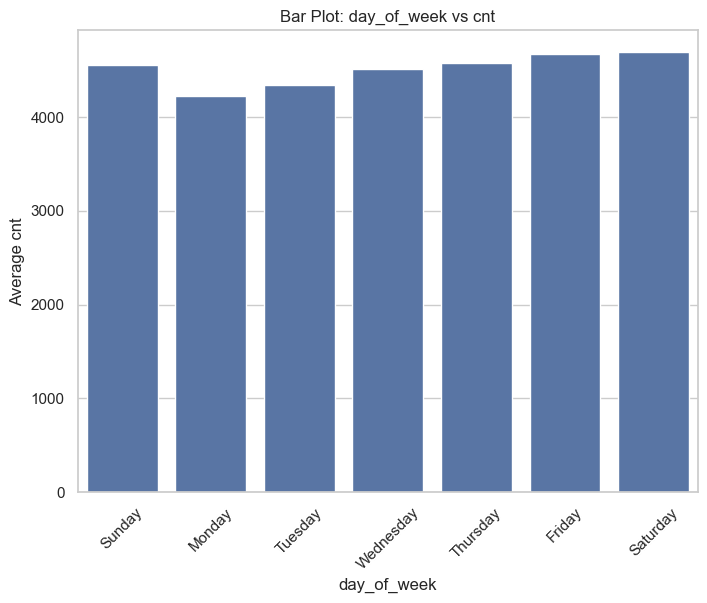

C:\Users\aichb\AppData\Local\Temp\ipykernel_20996\2762058177.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=col, y='cnt', ci=None)


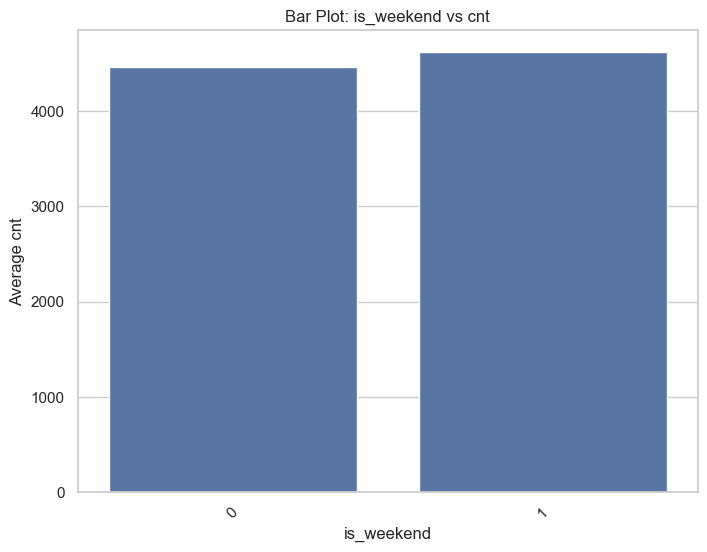

In [55]:
"""
o	Use scatterplots for numeric features and bar plots for categorical features.
generate scatterplots for numeric features and bar plots for categorical features based on the given dataset
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplots for numeric features
numeric_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'casual_registered_ratio']
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col, y='cnt')
    plt.title(f'Scatterplot: {col} vs cnt')
    plt.xlabel(col)
    plt.ylabel('cnt')
    plt.show()

# Bar plots for categorical features
categorical_columns = ['holiday', 'weekday', 'workingday', 'day_of_week', 'is_weekend']
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x=col, y='cnt', ci=None)
    plt.title(f'Bar Plot: {col} vs cnt')
    plt.xlabel(col)
    plt.ylabel('Average cnt')
    plt.xticks(rotation=45)
    plt.show()

In [15]:
"""
•	Check for multicollinearity using a correlation matrix or Variance Inflation Factor (VIF).
"""

from statsmodels.stats.outliers_influence import variance_inflation_factor


"""
    Calculate Variance Inflation Factor (VIF) for each feature in the dataset.
    :param data: DataFrame containing features
    :return: DataFrame with features and their VIF values
"""
# Handle Multicollinearity using VIF
def calculate_vif(data):
    
    # Ensure data is numeric
    numeric_data = data.select_dtypes(include=[np.number])
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_data.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
    return vif_data

# Calculate VIF for the original features
vif_df = calculate_vif(df)
print("VIF before dropping collinear features:")
print(vif_df)

# Drop highly collinear features (VIF > 10)
threshold = 10
non_collinear_features = vif_df[vif_df["VIF"] <= threshold]["feature"].tolist()
filtered_df = df[non_collinear_features]

# Recalculate VIF after dropping collinear features
vif_df_filtered = calculate_vif(filtered_df)
print("VIF after dropping collinear features:")
print(vif_df_filtered)

VIF before dropping collinear features:
                    feature    VIF
0                        yr    inf
1                   holiday   1.15
2                   weekday  10.66
3                workingday   9.77
4                      temp 532.47
5                     atemp 617.71
6                       hum  25.79
7                 windspeed   8.48
8                    casual    inf
9                registered    inf
10                      cnt    inf
11  casual_registered_ratio  20.88
12                     year    inf
13                    month   5.69
14               is_weekend   5.12
VIF after dropping collinear features:
      feature  VIF
0     holiday 1.10
1  workingday 2.93
2   windspeed 3.62
3       month 3.10
4  is_weekend 1.43


C:\Users\aichb\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [17]:

"""
##Model Building
Define Target and Features
We will set cnt as the target variable (y).
We will exclude casual and registered from the features since they sum to cnt.

Data Splitting
We will split the data into training and test sets using train_test_split.
"""

import pandas as pd
from sklearn.model_selection import train_test_split

# Step 2.1: Define Target and Features
# Target variable: 'cnt'
y = df['cnt']

# Features: All columns except 'cnt', 'casual', 'registered' 
X = df.drop(columns=['cnt', 'casual', 'registered', 'dteday', 'day_of_week'])  # Excluding non-numeric columns

# Step 2.2: Data Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (511, 23)
X_test shape: (219, 23)
y_train shape: (511,)
y_test shape: (219,)


In [61]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply MinMaxScaler
normalized_data = minmax_scaler.fit_transform(df[['temp', 'atemp', 'hum', 'windspeed']])
normalized_df = pd.DataFrame(normalized_data, columns=['temp_norm', 'atemp_norm', 'hum_norm', 'windspeed_norm'])

# Apply StandardScaler
standardized_data = standard_scaler.fit_transform(df[['temp', 'atemp', 'hum', 'windspeed']])
standardized_df = pd.DataFrame(standardized_data, columns=['temp_std', 'atemp_std', 'hum_std', 'windspeed_std'])

# Concatenate original and scaled data
result_df = pd.concat([df, normalized_df, standardized_df], axis=1)

# Display result
print(result_df)

        dteday    yr  holiday  weekday  workingday  temp  atemp   hum  \
0   2018-01-01  2018        0        6           0 14.11  18.18 80.58   
1   2018-01-02  2018        0        0           0 14.90  17.69 69.61   
2   2018-01-03  2018        0        1           1  8.05   9.47 43.73   
3   2018-01-04  2018        0        2           1  8.20  10.61 59.04   
4   2018-01-05  2018        0        3           1  9.31  11.46 43.70   
..         ...   ...      ...      ...         ...   ...    ...   ...   
725 2019-12-27  2019        0        4           1 10.42  11.33 65.29   
726 2019-12-28  2019        0        5           1 10.39  12.75 59.00   
727 2019-12-29  2019        0        6           0 10.39  12.12 75.29   
728 2019-12-30  2019        0        0           0 10.49  11.59 48.33   
729 2019-12-31  2019        0        1           1  8.85  11.17 57.75   

     windspeed  casual  registered   cnt  casual_registered_ratio  year  \
0        10.75     331         654   985        

In [19]:
"""
Build a Baseline Linear Regression Model
•	Train a linear regression model using LinearRegression from scikit-learn.
•	Evaluate the model using metrics like:
o	R-squared (r2_score)
o	Mean Absolute Error (MAE)
o	Mean Squared Error (MSE)


"""

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 2.1: Define Target and Features
y = df['cnt']
X = df.drop(columns=['cnt', 'casual', 'registered', 'dteday', 'day_of_week'])  # Excluding non-numeric columns

# Step 2.2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 2.3: Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 2.4: Make Predictions
y_pred = model.predict(X_test)

# Step 2.5: Evaluate the Model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Display Evaluation Metrics
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")


R-squared: 0.8076
Mean Absolute Error (MAE): 626.2784
Mean Squared Error (MSE): 713993.0163


In [21]:
"""
Feature Selection
•	Use techniques like Recursive Feature Elimination (RFE)  to identify significant predictors.

"""

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Step 2.1: Define Target and Features
y = df['cnt']
X = df.drop(columns=['cnt', 'casual', 'registered', 'dteday', 'day_of_week'])  # Excluding non-numeric columns

# Step 2.2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# =============================================================================
# Standardize the features (important for Lasso regression)
# =============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# Feature Selection using Recursive Feature Elimination (RFE)
# =============================================================================
# Using a linear regression model for feature selection
linear_model = LinearRegression()

# RFE: Recursively eliminate features and rank them by importance
selector = RFE(linear_model, n_features_to_select=5)  # Select top 5 features
selector = selector.fit(X_train_scaled, y_train)

# List the selected features
selected_features_rfe = X_train.columns[selector.support_]
print(f"Selected features using RFE: {selected_features_rfe}")





Selected features using RFE: Index(['yr', 'workingday', 'atemp', 'casual_registered_ratio', 'year'], dtype='object')


In [78]:
"""
: Model Refinement
•	Tune the model using:
o	Polynomial features (if non-linearity exists).
o	Ridge or Lasso regression for regularization

"""

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd

# Step 1: Define Target and Features
y = df['cnt']
X = df.drop(columns=['cnt', 'casual', 'registered', 'dteday', 'day_of_week'])  # Excluding non-numeric columns

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Polynomial Features
poly = PolynomialFeatures(degree=2)  # Degree can be adjusted to capture more complexity
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Step 5: Model Refinement with Ridge or Lasso Regression
# You can choose between Ridge or Lasso, or use both for comparison.
ridge = Ridge(alpha=1.0)  # You can adjust alpha for regularization strength
lasso = Lasso(alpha=0.1)  # You can adjust alpha for regularization strength

# Creating a pipeline with PolynomialFeatures and Ridge regression (you can try Lasso here as well)
ridge_pipeline = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1.0))
lasso_pipeline = make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=0.1))

# Step 6: Train the Model using Ridge or Lasso
ridge_pipeline.fit(X_train, y_train)
lasso_pipeline.fit(X_train, y_train)

# Step 7: Model Evaluation

# Ridge Model
y_pred_ridge = ridge_pipeline.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge = np.mean(np.abs(y_test - y_pred_ridge))

print(f"Ridge Regression Evaluation:")
print(f"R-squared: {r2_ridge:.4f}")
print(f"Mean Squared Error (MSE): {mse_ridge:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ridge:.4f}\n")

# Lasso Model
y_pred_lasso = lasso_pipeline.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso = np.mean(np.abs(y_test - y_pred_lasso))

print(f"Lasso Regression Evaluation:")
print(f"R-squared: {r2_lasso:.4f}")
print(f"Mean Squared Error (MSE): {mse_lasso:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lasso:.4f}")


Ridge Regression Evaluation:
R-squared: 0.8576
Mean Squared Error (MSE): 528428.3024
Mean Absolute Error (MAE): 546.3904

Lasso Regression Evaluation:
R-squared: 0.8705
Mean Squared Error (MSE): 480367.6905
Mean Absolute Error (MAE): 524.5214


C:\Users\aichb\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.509e+07, tolerance: 1.916e+05
  model = cd_fast.enet_coordinate_descent(


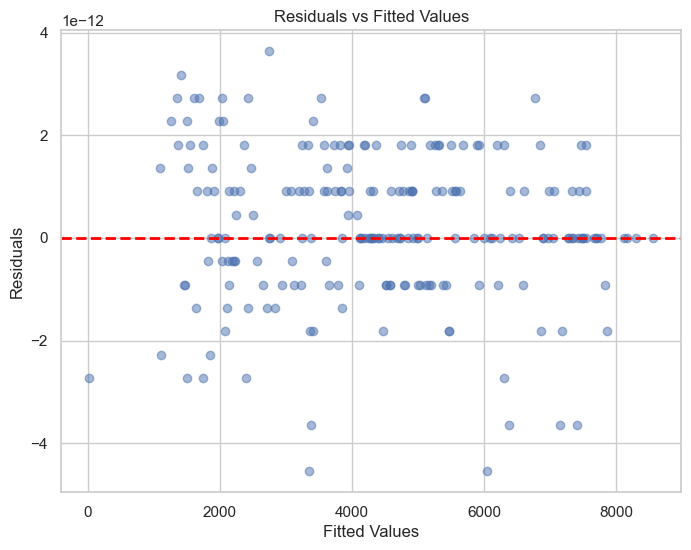

<Figure size 800x600 with 0 Axes>

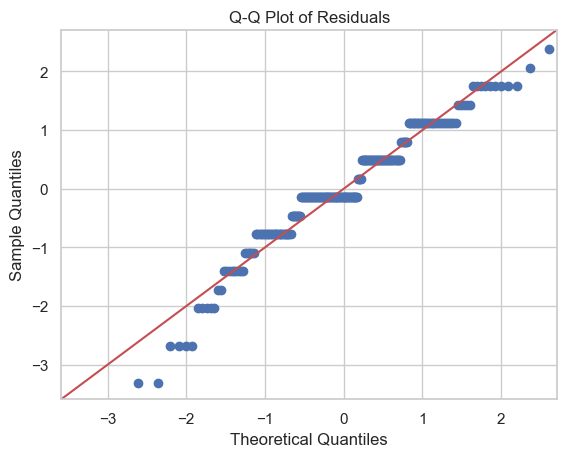

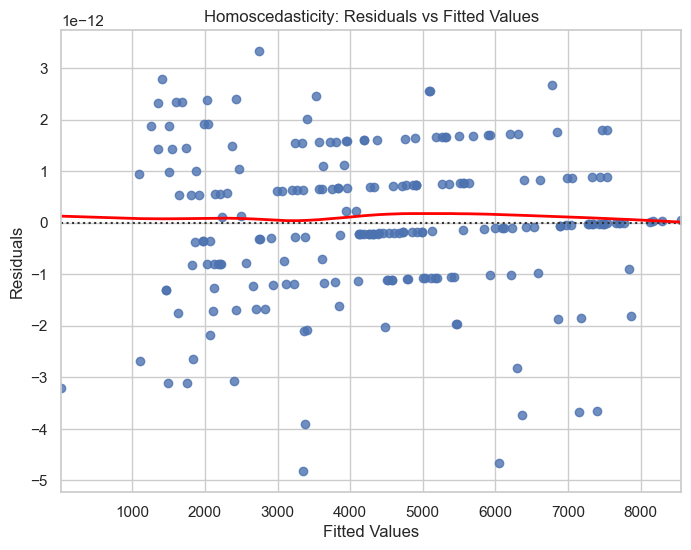

Mean of residuals: 2.0972366410745604e-13
Standard deviation of residuals: 1.4394878573590938e-12
Training Mean Squared Error (MSE): 0.00
Testing Mean Squared Error (MSE): 0.00


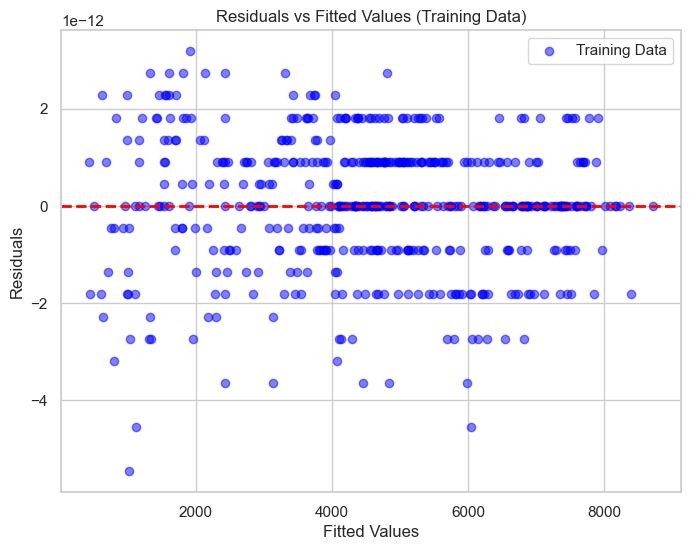

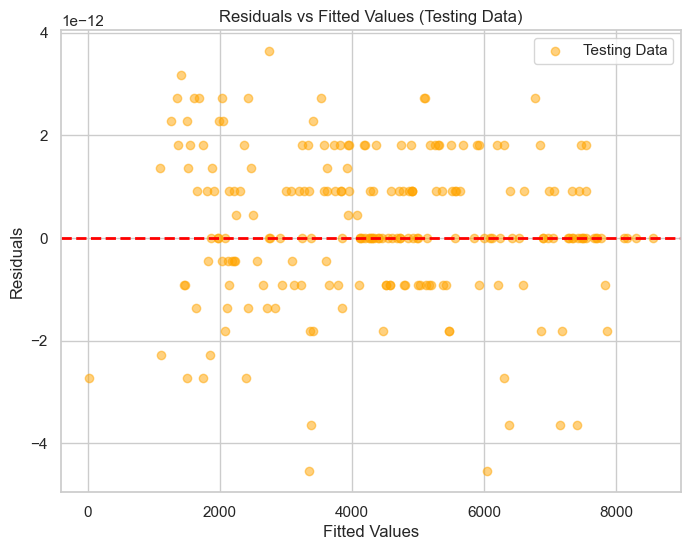

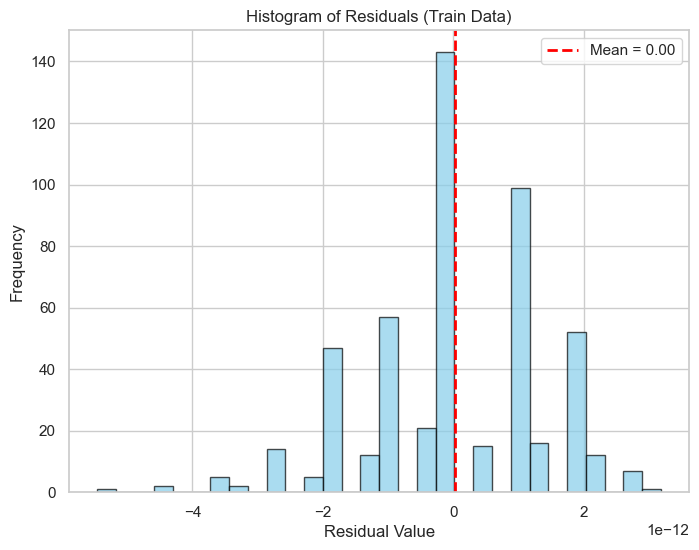

Mean of residuals (Train Data): 0.00


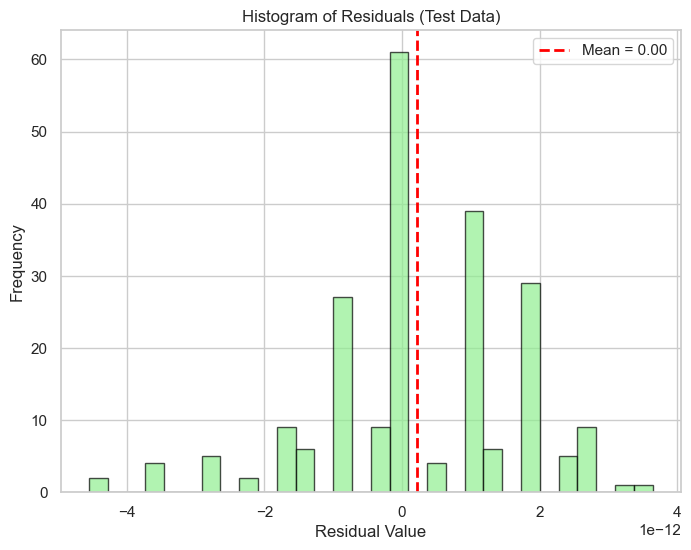

Mean of residuals (Test Data): 0.00


In [82]:
"""
Model Evaluation
: Residual Analysis
•	Perform residual analysis to validate assumptions:
o	Residuals should have a mean close to zero.

o	Check for homoscedasticity (constant variance) using a residuals vs. fitted plot.
o	Verify normality of residuals using a Q-Q plot.

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Sample dataset preparation (make sure your dataset is in the same structure)
# Assuming df is already loaded and pre-processed

# 1. Check for missing values and handle them
if df.isnull().any().any():
    print("There are missing values in the dataset. Filling with mean values.")
    df = df.fillna(df.mean())  # Or use other methods like forward-fill, backward-fill, etc.

# 2. Exclude non-numeric or irrelevant columns (assuming 'cnt' is the target and 'dteday' is a datetime column)
X = df.drop(columns=['cnt', 'dteday'])  # Excluding non-numeric columns
y = df['cnt']

# 3. Check that all remaining columns in X are numeric
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

# 4. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Standardize the features (important for regression models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Residuals
residuals = y_test - y_pred

# 1. Linearity: Residuals vs Fitted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# 2. Normality of residuals: Q-Q plot
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# 3. Homoscedasticity: Residuals vs Fitted Values again checks this
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.title('Homoscedasticity: Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Summary statistics of residuals
print("Mean of residuals:", np.mean(residuals))
print("Standard deviation of residuals:", np.std(residuals))


# 5. Train the Model
# Training the model on the training set (already done above)

# Generate predictions for both training and testing datasets
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Evaluate the model performance on training and testing datasets
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Print the MSE for training and testing datasets
print(f"Training Mean Squared Error (MSE): {train_mse:.2f}")
print(f"Testing Mean Squared Error (MSE): {test_mse:.2f}")

# Residuals for training and testing datasets
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# 1. Linearity: Plot residuals vs fitted values for training dataset
plt.figure(figsize=(8, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.5, label='Training Data', color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Fitted Values (Training Data)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# 2. Linearity: Plot residuals vs fitted values for testing dataset
plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred, test_residuals, alpha=0.5, label='Testing Data', color='orange')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs Fitted Values (Testing Data)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()


# Histogram of Residuals for Train Data
plt.figure(figsize=(8, 6))
plt.hist(train_residuals, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
plt.axvline(train_residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {train_residuals.mean():.2f}')
plt.title('Histogram of Residuals (Train Data)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate the mean of residuals
residual_mean = train_residuals.mean()
print(f"Mean of residuals (Train Data): {residual_mean:.2f}")

# Perform a similar analysis for Test Data
plt.figure(figsize=(8, 6))
plt.hist(test_residuals, bins=30, edgecolor='black', color='lightgreen', alpha=0.7)
plt.axvline(test_residuals.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {test_residuals.mean():.2f}')
plt.title('Histogram of Residuals (Test Data)')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate the mean of residuals for test data
test_residual_mean = test_residuals.mean()
print(f"Mean of residuals (Test Data): {test_residual_mean:.2f}")


In [86]:

"""
Evaluating on Test Data and Computing R-squared
"""
from sklearn.metrics import r2_score

# Predict on the test set using the trained model
y_pred = model.predict(X_test_scaled)

# Compute R-squared on the test set
r2_test = r2_score(y_test, y_pred)

# Print the R-squared value
print("R-squared on test set:", r2_test)

R-squared on test set: 1.0


In [88]:

"""
identify which features contribute most to predicting the target variable and how they influence it.

This analysis helps identify which features are most influential in predicting the target variable (cnt).
By looking at the coefficients and p-values, can summarize the relationships between predictors and the target variable
"""

import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming 'df' is the dataset loaded and pre-processed

# Exclude non-numeric or irrelevant columns (assuming 'cnt' is the target and 'dteday' is a datetime column)
X = df.drop(columns=['cnt', 'dteday'])
y = df['cnt']

# Select only numeric columns
X = X.select_dtypes(include=[np.number])

# Add a constant (intercept) to the model (required for statsmodels)
X_const = sm.add_constant(X)

# Fit the model using statsmodels (OLS)
model = sm.OLS(y, X_const).fit()

# Display the summary of the model
print(model.summary())

# Get the coefficients and their p-values
coefficients = model.params
p_values = model.pvalues

# Print out significant predictors
significant_predictors = coefficients[p_values < 0.05]

print("\nSignificant Predictors and Their Coefficients:")
print(significant_predictors)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.139e+26
Date:                Fri, 20 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:45:52   Log-Likelihood:                 13876.
No. Observations:                 730   AIC:                        -2.772e+04
Df Residuals:                     716   BIC:                        -2.766e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    8